In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.models as models

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

### Prior to training I saved the dataset as .npy files so that it is easier to transfer them:
no.npy, sphere.npy and vort.npy in \train folder and the same names in the \val folder

In [2]:
class NpyClassDataset(torch.utils.data.Dataset):
    def __init__(self, folder, label_map, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform

        for fname, label in label_map.items():
            path = os.path.join(folder, fname)
            data = np.load(path)  # shape: (N, 150, 150)
            data = data[:, None, :, :]  # add channel dim → (N, 1, 150, 150)
            self.images.append(torch.tensor(data, dtype=torch.float32))
            self.labels += [label] * data.shape[0]

        self.images = torch.cat(self.images, dim=0)
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

### Data loading and augmentation for the training set

In [3]:
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), 
    transforms.RandomRotation(90)            
])

In [4]:
label_map = {'no.npy': 0, 'sphere.npy': 1, 'vort.npy': 2}

train_ds = NpyClassDataset(r'./train/',label_map, transform = transform_train)
val_ds = NpyClassDataset(r'./val/',label_map)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True)

### To use pretrained resnet18 it needs to be customised for the single input channel and 3 outputs

In [5]:
def get_resnet18_grayscale(num_classes):
    model = models.resnet18(weights='IMAGENET1K_V1')  

    original_conv = model.conv1

    new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=original_conv.out_channels,
    kernel_size=original_conv.kernel_size,
    stride=original_conv.stride,
    padding=original_conv.padding,
    bias=original_conv.bias is not None
    )

    with torch.no_grad():
        new_conv.weight[:] = original_conv.weight.mean(dim=1, keepdim=True)

    model.conv1 = new_conv
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

### Initializing the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_resnet18_grayscale(num_classes=3).to(device)

### Training the model

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

log_file = "log_test1/training_log.txt"
os.makedirs(os.path.dirname(log_file), exist_ok=True)

with open(log_file, 'w') as f:
    for epoch in range(3):
        running_train_loss = 0.0
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_train_loss / len(train_loader.dataset)
    
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = correct / total

        log_line = (f"Epoch {epoch+1}: "
                    f"Train Loss = {avg_train_loss:.4f}, "
                    f"Val Loss = {avg_val_loss:.4f}, "
                    f"Val Acc = {val_accuracy:.4f}")
        print(log_line)
        f.write(log_line + '\n')

torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pt')

Epoch 1: Train Loss = 1.0419, Val Loss = 0.8528, Val Acc = 0.5800
Epoch 2: Train Loss = 0.7237, Val Loss = 0.6289, Val Acc = 0.7215
Epoch 3: Train Loss = 0.5717, Val Loss = 0.5749, Val Acc = 0.7664


### Loading previously trained model

In [ ]:
model.load_state_dict(torch.load('test_1.pt'))

### Evaluating the model on the validation set and obtaining ROC and AUC

In [7]:
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)  # raw logits
        probs = torch.softmax(outputs, dim=1)  # probabilities
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Stack results
all_probs = np.vstack(all_probs)
all_labels = np.concatenate(all_labels)

In [8]:
n_classes = 3
y_true = label_binarize(all_labels, classes=[0, 1, 2])  # shape: (N, 3)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

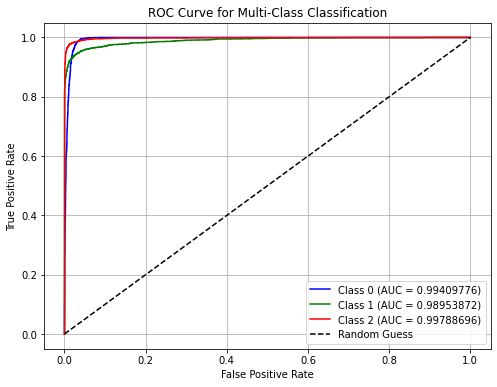

In [9]:
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"Class {i} (AUC = {roc_auc[i]:.8f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.grid()
plt.show()
